In [1]:
import sys
import numpy as np

PI = np.pi
SIN = np.sqrt(3)/2.0
CONST1 = 2/np.sqrt(6)
CONST2 = 1/np.sqrt(2)

#### 逆格子空間での射影

In [2]:
def prjctn_recipro_par(r,a=1.0,c=1.0):
    """
    parallel component of 5D reciprocal lattice vector
    input
    list:r, 5D reflection index
    float:a, lattice constant
    float:c, lattice constant
    """
    x = (1*r[0]+SIN*r[1]+0.5*r[2]       )/a*CONST2
    y = (       0.5*r[1]+SIN*r[2]+1*r[3])/a*CONST2
    z = r[4]/c
    return [x,y,z]

def prjctn_recipro_perp(r,a=1.0):
    """
    perpendicular component of 5D reciprocal lattice vector
    input
    list:r, 4D reflection index
    float:a, lattice constant
    """
    x=(1*r[0]-SIN*r[1]+0.5*r[2]     )/a*CONST2
    y=(       0.5*r[1]-SIN*r[2]+r[3])/a*CONST2
    return [x,y]


In [3]:
def prjctn_recipro_par_length(r,a=1.0,c=1.0):
    [x,y,z]=prjctn_recipro_par(r,a,c)
    return np.sqrt(x**2+y**2+z**2)

def prjctn_recipro_perp_length(r,a=1.0):
    [x,y]=prjctn_recipro_perp(r,a)
    return np.sqrt(x**2+y**2)


#### 実空間での射影

In [4]:
def prjctn_direct_par_length(r,a=1.0,c=1.0):
    [x,y,z]=prjctn_direct_par(r,a,c)
    return np.sqrt(x**2+y**2+z**2)

def prjctn_direct_perp_length(r,a=1.0):
    [x,y]=prjctn_direct_perp(r,a)
    return np.sqrt(x**2+y**2)


In [5]:
def prjctn_direct_par(r,a=1.0,c=1.0):
    """
    parallel component of 5D reciprocal lattice vector
    input
    list:r, 5D reflection index
    float:a, lattice constant
    float:c, lattice constant
    """
    x = ( SIN*r[0]+r[1]     -0.5*r[3])*a*CONST1
    y = (-0.5*r[0]     +r[2]+SIN*r[3])*a*CONST1
    z = r[4]*c
    return [x,y,z]

def prjctn_direct_perp(r,a=1.0):
    """
    perpendicular component of 5D reciprocal lattice vector
    input
    list:r, 5D reflection index
    float:a, lattice constant
    """
    x = (-SIN*r[0]+r[1]-0.5*r[3])*a*CONST1
    y = (-0.5*r[0]+r[2]-SIN*r[3])*a*CONST1
    return [x,y]


#### 回折角

In [6]:
def reflection_angle(wvl,hklmno,a,c):
    """
    return theta-angle in rad.
    """
    qpar = prjctn_recipro_par_length(hklmno,a,c)
    theta = np.arcsin(qpar*wvl/2)
    return theta


#### フーリエ変換

In [7]:
import math
# from scipy import integrate
import cmath

In [8]:
PI = np.pi
TWOPI = 2.0*PI

In [9]:
def calc_FT(hkl,xyz):
    """
    格子のフーリエ変換の計算
    see
    Yamamoto, qcdiff, qcdiff1.f90, L.1789, subroutine stfcd(h,f,fn,dfdxx,q,ny,dfdbia)

    input:

    :param array hkl:
    :param array xyz:
    """
    val = 0.0+0.0*1j
    #print('  hkl = ',hkl)
    #print('  xyz = ',xyz)
    if xyz.ndim == 1:
        con1 = np.dot(hkl,xyz)
        #print('  con1 = ',con1)
        val = cmath.exp(TWOPI*con1*1j)
    elif xyz.ndim == 2:
        for i in range(len(xyz)):
            con1 = np.dot(hkl,xyz[i])
            val += cmath.exp(TWOPI*con1*1j)
    else:
        print('check your model')
    return val

In [10]:
def calc_od_FT(shape,obj,hkl,position,site_symmetry,flag=0,ad=1.0,scl=1.0,eps=1E-3):
    """This returns Fourier integral of an occupation domain.

    Parameters
    ----------
    shape: str
        shape of the occupation domain.
    obj: list
        occupation domain(set of triangle)
    hkl: list
        reflection index
    position: ndarray
        centre position of the od
    site_symmetry: list
        index of symmetry operation of the site symmetry
    flag: int
        (0) the model is centre symmetric
        (1) the model is not centre symmetric
    ad: float
        dodecagonal lattica constant
    scl: float
        scale
    eps: float

    Returns
    -------
    """
    if shape == 'triangle':
        if site_symmetry==[-1]: # symmetric ODs
            od=obj
        else: # asymmetric unit of ODs
            od=generator_obj_symmetric_obj_specific_symop(obj,position,site_symmetry)
            #n1,n2,n3,n4,n5=od.shape
            #od=od.reshape(n1*n2,n3,n4,n5)
        return fpoly(od,hkl,flag,ad,scl,eps)

    else:
        print('OD shape error')
        return

In [11]:
def fpoly(od,hkl,flag,ad,scl,eps):
    """This function returns Fourier integral of an indipendent occupation domain (multi-triangles)

    Parameters
    ----------
    od: list
        occupation domain(set of triangle)
    hkl: list
        reflection index
    site: ndarray
        centre position of the od
    ad: float
        dodecagonal lattica constalt
    scl: float
        scale
    flag: int
        (0) od
        (1) inversion of od is used for calculation
    eps: float

    Returns
    -------
    """
    out=0.0+0.0*1j
    for triangle in od:
        e1=triangle[1]-triangle[0]
        e2=triangle[2]-triangle[0]
        e1 = prjctn_direct_perp(e1,ad)
        e2 = prjctn_direct_perp(e2,ad)
        out+=fourier2d_qcdiff_0(e1,e2,hkl,ad,scl,eps)
    if flag==0:
        return out
    else:
        # odに反転操作を行ったもののフーリエ変換は、odのフーリエ変換の共役になる。
        return out.conjugate()

In [12]:
def fourier2d_qcdiff_0(e1i,e2i,hkl,ad,scl,eps):
    """
    Fourier integral of a triangle defined by e1 and e2.
    Reference:
    Yamamoto, qcdiff, occupdom.f90, L.956, complex function fq0d(hr,e1,e2,v,rmax,dfqdr)

    input:

    :param vertex coordinates of the triangle, e1 and e2
    :param nd.array: hkl
    :param float: ad
    :param float: scl (= rmax, in qcdiff)
    :param float: eps
    """
    #projection onto the internal space of reflection indices
    qi = prjctn_recipro_perp(hkl,ad)
    qi = np.array(qi)

    #volume of the triangle
    vol = abs(np.cross(e1i,e2i))/2.0*scl**2

    q1 = TWOPI*np.dot(qi,e1i)*scl
    q2 = TWOPI*np.dot(qi,e2i)*scl
    q3 = q1-q2 # ここ重要：q2-q1ではない！

    cexp01 = cmath.exp(1j*q1)-1
    cexp02 = cmath.exp(1j*q2)-1
    cexp1 = cmath.exp(1j*q1)-1-1j*q1
    cexp2 = cmath.exp(1j*q2)-1-1j*q2
    dcq1dq = 1j*cmath.exp(1j*q1)-1j

    if abs(q1)<eps and abs(q2)<eps:
        val = vol/2.0
    elif abs(q1)<eps:
        val = -vol*cexp2/q2**2
    elif abs(q2)<eps:
        val = -vol*cexp1/q1**2
    elif abs(q3)<eps:
        val = vol*(cexp1/q1**2-dcq1dq/q1)
    else:
        val = vol*(q1*cexp02-q2*cexp01)/(q1*q2*q3)

    return val

#### ODの定義

In [13]:
od_B = []
tr1 = [[0,0,0,0,0],[0,1,0,0,0],[-1,0,0,0,0]]
tr2 = [[0,0,0,0,0],[-1,0,0,0,0],[0,0,0,-1,0]]
tr3 = [[0,0,0,0,0],[0,0,0,-1,0],[0,0,1,0,0]]
tr4 = [[0,0,0,0,0],[0,0,1,0,0],[0,-1,0,-1,0]]
tr5 = [[0,0,0,0,0],[0,-1,0,-1,0],[1,0,1,0,0]]
tr6 = [[0,0,0,0,0],[1,0,1,0,0],[0,-1,0,0,0]]
tr7 = [[0,0,0,0,0],[0,-1,0,0,0],[1,0,0,0,0]]
tr8 = [[0,0,0,0,0],[1,0,0,0,0],[0,0,0,1,0]]
tr9 = [[0,0,0,0,0],[0,0,0,1,0],[0,0,-1,0,0]]
tr10 = [[0,0,0,0,0],[0,0,-1,0,0],[0,1,0,1,0]]
tr11 = [[0,0,0,0,0],[0,1,0,1,0,],[-1,0,-1,0,0]]
tr12 = [[0,0,0,0,0],[-1,0,-1,0,0],[0,1,0,0,0]]

od_B = np.array([tr1,tr2,tr3,tr4,tr5,tr6,tr7,tr8,tr9,tr10,tr11,tr12])

In [14]:
# od_B = []
# tr1 = [[0,0,0,0,0],[0,1,0,0,0],[0,0,0,-1,0]]
# tr2 = [[0,0,0,0,0],[-1,0,0,0,0],[0,0,1,0,0]]
# tr3 = [[0,0,0,0,0],[0,0,0,-1,0],[0,-1,0,-1,0]]
# tr4 = [[0,0,0,0,0],[0,0,1,0,0],[1,0,1,0,0]]
# tr5 = [[0,0,0,0,0],[0,-1,0,-1,0],[0,-1,0,0,0]]
# tr6 = [[0,0,0,0,0],[1,0,1,0,0],[1,0,0,0,0]]
# tr7 = [[0,0,0,0,0],[0,-1,0,0,0],[0,0,0,1,0]]
# tr8 = [[0,0,0,0,0],[1,0,0,0,0],[0,0,-1,0,0]]
# tr9 = [[0,0,0,0,0],[0,0,0,1,0],[0,1,0,1,0]]
# tr10 = [[0,0,0,0,0],[0,0,-1,0,0],[-1,0,-1,0,0]]
# tr11 = [[0,0,0,0,0],[0,1,0,1,0],[0,1,0,0,0]]
# tr12 = [[0,0,0,0,0],[-1,0,-1,0,0],[-1,0,0,0,0]]

# od_B = np.array([tr1,tr3,tr5,tr7,tr9,tr11])

In [15]:
# od_A = []

# od_A = np.array([tr2,tr4,tr6,tr8,tr10,tr12])

#### 指数発生

In [16]:
EPS=1E-6

#### 原子散乱因子

In [17]:
import atom as at


In [18]:
def calc_asf(element, theta): # Atomic scattering factor
    p = at.aff_parameters[element]
    a = [p[0], p[2], p[4], p[6], p[8]]
    b = [p[1], p[3], p[5], p[7], p[9]]
    c = p[10]
    sum_ = 0.0
    for i in range(5):
        sum_ = sum_+ a[i]*math.exp(-1.0*b[i]*math.sin(theta/180.0*np.pi)**2.0/wvl**2.0)
    return sum_+c

#### ローレンツ因子

In [19]:
def calc_LP(theta): #Lorentz-polarization factor
    p1=math.cos(2.0*theta/180.0*np.pi)
    p2=math.sin(theta/180.0*np.pi)
    p3=math.cos(theta/180.0*np.pi)
    return (1.0+p1**2.0)/p2**2.0/p3

#### 温度因子

In [20]:
B_par = 1.519
B_perp = 54.00



In [21]:
def temfact(B_par,B_perp,g_par,g_perp):
    # for g in peaks_dict.values():
    return math.exp(-(B_par*g_par**2+B_perp*g_perp**2)/4)



#### ローレンツ関数畳み込み

In [22]:
def Lorenz(p, x): #Lorenzian
    return ((p[0]*p[1]**2/((x-p[2])**2+p[1]**2)))

In [23]:
def read_file(file):
    """
    read a file
    input: 
    :param file: file name of the imput.
    """
    try:
        f=open(file,'r')
    except IOError as e:
        print(e)
        sys.exit(0)
    line=[]
    while 1:
        a=f.readline()
        if not a:
            break
        line.append(a[:-1])
    return line

In [24]:
reflist = read_file("./reflection_list.ref")

In [25]:
# print(reflist)

In [26]:
peaks_dict = {}
for i in range(1,len(reflist)):
    b = reflist[i].split()
    hklmno = np.array([int(b[0]),int(b[1]),int(b[2]),int(b[3]),int(b[4])])
    multiplicity = int(b[5])
    g_par = float(b[6])
    g_perp = float(b[7])
    peaks_dict[i] = [hklmno,multiplicity,g_par,g_perp]
    # print(hklmno)
    # print(multiplicity)
    #print(g_par)
    #print(g_perp)
# print(peaks_dict)
    # print(multiplicity)

#### 構造因子の計算

In [27]:
import tqdm

def structure_factor(peaks_dict,a,c,wvl,myModel,elm_A,elm_B,flag,p):
    theta_list = []
    intensity_dict = {}
    for nref in peaks_dict:
        hklmno, multiplicity,g_par,g_perp = peaks_dict[nref]
        theta=reflection_angle(wvl,hklmno,a,c) # in rad.
        # if theta in theta_list:
        #     continue
        # else:
        #     theta_list.append(theta)
        q_par_len=2*math.sin(theta)/wvl # in Ang*{-1}
        if theta>0. and theta<PI/2.0:
            position,shape,obj,site_symmetry = myModel
            xaxis = 2*theta/PI*180 # tth in degree
            xaxis = round(xaxis,3)
            pos_FT = calc_FT(hklmno,position)
            od_FT = calc_od_FT(shape,obj,hklmno,position,site_symmetry,flag=0,ad=1.0,scl=1.0,eps=1E-3)
            # print(od_FT)
            # asf = calc_asf(element, xaxis)
            
            # pos_FT1 = calc_FT(hklmno,position)
            # pos_FT2 = calc_FT(hklmno,position2)
            
            # od_FT1 = calc_od_FT(shape,obj_A,hklmno,position,site_symmetry)  
            # # od_FT2 = calc_od_FT(shape,obj_B,hklmno,position,site_symmetry,1)   
            # od_FT2 = calc_od_FT(shape,obj_B,hklmno,position,site_symmetry)
                        
            asf1 = calc_asf(elm_A, xaxis)
            asf2 = calc_asf(elm_B, xaxis)

            # 2024.12.05 TY modified.
            #TF = temfact(B_par,B_perp,g_par,g_perp) 
            q_per_len=prjctn_recipro_perp_length(hklmno)
            TF = temfact(B_par,B_perp,q_par_len,q_per_len)
            
            LP = calc_LP(xaxis)
            # # sfacs += pos_FT1*od_FT1*asf1*TF
            # # sfacs += pos_FT2*od_FT2*asf2*TF
            # sfacs1 = pos_FT1*od_FT1*asf1*TF
            # sfacs2 = pos_FT2*od_FT2*asf2*TF
            # sfacs = sfacs1+sfacs2

            sfacs1 = pos_FT*od_FT*p*asf1*TF
            sfacs2 = pos_FT*od_FT*(1-p)*asf2*TF
            sfacs = sfacs1+sfacs2
            # sfacs = pos_FT*od_FT*asf*TF
            intensity = LP*multiplicity*(sfacs.real**2 + sfacs.imag**2)
            # print(multiplicity)
            # multiplicity*

            #xaxis = 2*theta/PI*180 # tth in degree
            #xaxis = round(xaxis,3)

            #Lorenz factor
            #lpf = factor_Lorenz(theta) # theta in rad.
            #intensity = lpf*multiplicity*(sfacs.real**2 + sfacs.imag**2)
            try:
                intensity_dict[xaxis] += intensity.real
            except:
                intensity_dict[xaxis] = intensity.real
        else:
            pass
    return intensity_dict

In [28]:
import generator as gm
print(gm.mattrix_dodeca_sym())

(array([[ 0,  1,  0,  0,  0],
       [ 0,  0,  1,  0,  0],
       [ 0,  0,  0,  1,  0],
       [-1,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  1]]), array([[ 0,  0,  1,  0,  0],
       [ 0,  1,  0,  0,  0],
       [ 1,  0,  0,  0,  0],
       [ 0,  1,  0, -1,  0],
       [ 0,  0,  0,  0,  1]]), array([[0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1]]), array([[-1,  0,  0,  0,  0],
       [ 0, -1,  0,  0,  0],
       [ 0,  0, -1,  0,  0],
       [ 0,  0,  0, -1,  0],
       [ 0,  0,  0,  0, -1]]))


In [29]:
hmax=5
lmax=4
a=7.886
c=10.403

wvl_dic={} #X線の波長
wvl_dic['Cu_Ka'] = 1.54059 # in Ang.
wvl_dic['Mo_Ka'] = 0.71069 # in Ang.
wvl = wvl_dic['Cu_Ka']
# element = 'Ta'

qemax = 2/wvl # in Ang.^{-1}
qimax = 0.5

flag = 'unique'

__,__,__,symop_inv = gm.mattrix_dodeca_sym()

#五次元構造の情報
#五次元格子の各頂点に占有領域Aがある
position = np.array([0,0,0,0,0]) #占有領域od_Bの中心位置
position2 = np.dot(symop_inv,position)

#占有領域Aの定義
shape = 'triangle'
# obj_A = od_A
# obj_B = od_B
obj = od_B
site_symmetry = [-1]
myModel = [position,shape,obj,site_symmetry]

# elm_A = 'Al'
# elm_B = 'Mn'

# elm_A = 'Al'
# elm_B = 'Ta'


# inten_dict = structure_factor(peaks_dict,a,c,wvl,myModel,elm_A,elm_B,flag)

In [30]:
#peaks_dict

In [31]:
# inten_dict

In [32]:
tth_min=0
tth_max=60
tth_step=0.01
data_num=3

In [33]:
import random

In [34]:
# import numpy as np
# from cython import boundscheck, wraparound
# import math
# # from libc.math cimport sin as csin
# # from libc.math cimport cos as ccos
# # from libc.math cimport asin as casin
# # from libc.math cimport exp as cexp
# import random
# import glob
# import tqdm

# PI = math.pi
# TWOPI = 2.0*PI
# TAU = (1.0+math.sqrt(5))/2.0
# CONST1 = 1.0/2.0/math.sqrt(TAU+2)
# EPS = 1E-06


# DTYPE_int = np.int64
# DTYPE_double = np.float64
# # ctypedef np.int64_t DTYPE_int_t
# # ctypedef np.float64_t DTYPE_double_t



# def LorentzianProfile(p, x_array):
#     # Peak profile: Lorenzian
#     return ((p[0]*p[1]**2/((x_array - p[2])**2 + p[1]**2)))


# ###############
# ## Multi-iQC# #
# ###############

# def calc_multiQC(QC_vectors_list, xaxis_min, xaxis_max, xaxis_step):

#     strong_num_min, strong_num_max, weak_num_min, weak_num_max = 0, 30, 0, 100
#     multiQC_vectors_list = []
#     xaxis_array = np.arange(xaxis_min, xaxis_max, xaxis_step)
#     len_xaxis = len(xaxis_array)
#     data_num = len(QC_vectors_list)

#     for index in range(data_num):
#         # QC_vector, hwhm = QC_vectors_list[index]
#         # print(QC_vectors_list[index])
#         # QC_vector, hwhm = QC_vectors_list
#         for QC_vector, hwhm in QC_vectors_list:
#             strong_xaxis_list = []
#             weak_xaxis_list = []
#             strong_num = random.randint(strong_num_min, strong_num_max)
#             weak_num = random.randint(weak_num_min, weak_num_max)
#             if strong_num == weak_num == 0:
#                 multiQC_vectors_list.append(np.array([0.0]*len(xaxis_array)))
#                 continue
#             for __ in range(strong_num):
#                 strong_xaxis_list.append(random.uniform(xaxis_min, xaxis_max))
#             for __ in range(weak_num):
#                 weak_xaxis_list.append(random.uniform(xaxis_min, xaxis_max))
    
    
#             fake_vector = np.array([0.0]*len(xaxis_array))
#             for xaxis in strong_xaxis_list:
#                 Intensity = random.uniform(0.1, 1.0)
#                 Lorenzian_list = [Intensity, hwhm*random.uniform(0.95,1.0), xaxis]
#                 fake_vector += LorentzianProfile(Lorenzian_list, xaxis_array)
#             for xaxis in weak_xaxis_list:
#                 Intensity = random.uniform(0, 0.1)
#                 Lorenzian_list = [Intensity, hwhm*random.uniform(0.95,1.0), xaxis]
#                 fake_vector += LorentzianProfile(Lorenzian_list, xaxis_array)
    
#             fake_vector -= np.min(fake_vector)
#             fake_vector /= np.max(fake_vector)
    
#             if random.random() > 0.5:
#                 multiQC_vector = QC_vector*random.uniform(0.2,1.0) + fake_vector
#             else:
#                 multiQC_vector = QC_vector + fake_vector*random.uniform(0.0,1.0)
    
#             noise_list = []
#             for __ in range(len_xaxis):
#                 noise_list.append(random.uniform(0.0, 0.01))
#             noise_array = np.array(noise_list, dtype = DTYPE_double)
#             multiQC_vector += noise_array
#             multiQC_vector -= np.min(multiQC_vector)
#             multiQC_vector /= np.max(multiQC_vector)
#             multiQC_vectors_list.append(multiQC_vector)
    
#         return multiQC_vectors_list

In [35]:
%load_ext Cython

In [36]:
%%cython

import numpy as np
cimport numpy as np
cimport cython
from cython import boundscheck, wraparound
import math
from libc.math cimport sin as csin
from libc.math cimport cos as ccos
from libc.math cimport asin as casin
from libc.math cimport exp as cexp
import random
import glob
import tqdm

cdef double PI = math.pi
cdef double TWOPI = 2.0*PI
cdef double TAU = (1.0+math.sqrt(5))/2.0
cdef double CONST1 = 1.0/2.0/math.sqrt(TAU+2)
cdef double EPS = 1E-06

DTYPE_int = np.int64
DTYPE_double = np.float64
ctypedef np.int64_t DTYPE_int_t
ctypedef np.float64_t DTYPE_double_t



cdef np.ndarray[DTYPE_double_t, ndim = 1]  LorentzianProfile(list p, np.ndarray[DTYPE_double_t, ndim = 1] x_array):
    # Peak profile: Lorenzian
    return ((p[0]*p[1]**2/((x_array - p[2])**2 + p[1]**2)))


###############
## Multi-iQC# #
###############

cpdef np.ndarray calc_multiQC(list QC_vectors_list, double xaxis_min, double xaxis_max, double xaxis_step):
    cdef int strong_num_min, strong_num_max, weak_num_min, weak_num_max, len_xaxis, data_num, index, __, strong_num, weak_num
    cdef double hwhm, tth, Intensity
    cdef list multiQC_vectors_list, strong_xaxis_list, weak_xaxis_list, Lorenzian_list, noise_list
    cdef np.ndarray[DTYPE_double_t, ndim=1] xaxis_array, QC_vector, fake_vector, multiQC_vector, noise_array

    strong_num_min, strong_num_max, weak_num_min, weak_num_max = 0, 30, 0, 100
    multiQC_vectors_list = []
    xaxis_array = np.arange(xaxis_min, xaxis_max, xaxis_step)
    len_xaxis = len(xaxis_array)
    data_num = len(QC_vectors_list)

    for index in range(data_num):
        QC_vector, hwhm = QC_vectors_list[index]
        strong_xaxis_list = []
        weak_xaxis_list = []
        strong_num = random.randint(strong_num_min, strong_num_max)
        weak_num = random.randint(weak_num_min, weak_num_max)
        if strong_num == weak_num == 0:
            multiQC_vectors_list.append(np.array([0.0]*len(xaxis_array)))
            continue
        for __ in range(strong_num):
            strong_xaxis_list.append(random.uniform(xaxis_min, xaxis_max))
        for __ in range(weak_num):
            weak_xaxis_list.append(random.uniform(xaxis_min, xaxis_max))

        fake_vector = np.array([0.0]*len(xaxis_array))
        for xaxis in strong_xaxis_list:
            Intensity = random.uniform(0.1, 1.0)
            Lorenzian_list = [Intensity, hwhm*random.uniform(0.95,1.0), xaxis]
            fake_vector += LorentzianProfile(Lorenzian_list, xaxis_array)
        for xaxis in weak_xaxis_list:
            Intensity = random.uniform(0, 0.1)
            Lorenzian_list = [Intensity, hwhm*random.uniform(0.95,1.0), xaxis]
            fake_vector += LorentzianProfile(Lorenzian_list, xaxis_array)

        fake_vector -= np.min(fake_vector)
        fake_vector /= np.max(fake_vector)

        if random.random() > 0.5:
            multiQC_vector = QC_vector*random.uniform(0.2,1.0) + fake_vector
        else:
            multiQC_vector = QC_vector + fake_vector*random.uniform(0.0,1.0)

        noise_list = []
        for __ in range(len_xaxis):
            noise_list.append(random.uniform(0.0, 0.01))
        noise_array = np.array(noise_list, dtype = DTYPE_double)
        multiQC_vector += noise_array
        multiQC_vector -= np.min(multiQC_vector)
        multiQC_vector /= np.max(multiQC_vector)
        multiQC_vectors_list.append(multiQC_vector)

    return np.array(multiQC_vectors_list, dtype = DTYPE_double)

In [37]:
xaxis_min=0
xaxis_max=60
xaxis_step=0.01

In [38]:
data_list = []
multiQC_data_list=[]

# list1 = []
# list1.append(at.aff_parameters.keys())
list1 = list(at.aff_parameters.keys())

rng = np.random.default_rng()
for __ in tqdm.tqdm(range(data_num), desc='training data'):
    # a = random.randrange(7.0, 9.0, 0.025)
    # c = random.randrange(10.0, 12.0, 0.025)
    ##a
    start=7.0
    stop=9.0
    step=0.025
    a = random.randrange(int(start / step), int(stop / step) + 1) * step

    ##b
    start=10.0
    stop=12.0
    step=0.025
    b = random.randrange(int(start / step), int(stop / step) + 1) * step
    # a = rng.uniform(7.0, 9.0)
    # c = rng.uniform(10.0, 12.0)
    # a = 7.0
    # c = 10.0
    # element = np.random.choice(list(at.aff_parameters.keys()))

    # elm_A = np.random.choice(list(at.aff_parameters.keys()))
    # print(list(at.aff_parameters.keys()))
    # # popped_item = list(at.aff_parameters.keys()).pop(elm_A)
    # elm_B = np.random.choice(list(at.aff_parameters.keys()))
    
    elm_A = np.random.choice(list1)
    # popped_item = list1.pop(elm_A)
    list1.remove(str(elm_A))
    elm_B = np.random.choice(list1)
    list1.append(elm_A)
    # print(elm_A)
    # print(elm_B)
    hwhm = rng.uniform(0.03, 0.3)
    p = rng.uniform(0, 1)
    # element = 'Ta'
    # hwhm = 0.01
    inten_dict = structure_factor(peaks_dict,a,c,wvl,myModel,elm_A,elm_B,flag,p)
    len_pattern = int((tth_max-tth_min)/tth_step)
    vector=np.array([0.0]*len_pattern)
    tths = np.arange(tth_min, tth_max, tth_step)
    #print(tths)
    for tth in inten_dict.keys():
        #print(tth)
        # inten_dict[tth][0]
        vector += Lorenz([inten_dict[tth], hwhm*random.uniform(0.95,1.0), tth], tths)
    vector = vector/np.max(vector)
    # data_list.append(vector)
    data_list.append([vector, hwhm])
    # print(multiQC_data_list)

#     multiQC_data_list=[]
# multiQC_data_list=calc_multiQC(data_list, xaxis_min, xaxis_max, xaxis_step)
# np.list(data_list)
# data_list = list(data_list)
# data_array = np.array(data_list)

training data: 100%|██████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.04it/s]


In [39]:
# for __ in tqdm.tqdm(range(data_num), desc='Multi_QC data'):
multiQC_data_list=calc_multiQC(data_list, xaxis_min, xaxis_max, xaxis_step)
    
np.array(multiQC_data_list)
# np.save('virtual_QC/training_dodeca.npy', multiQC_data_list)

array([[0.0296927 , 0.0294766 , 0.03109405, ..., 0.01227675, 0.01163895,
        0.009139  ],
       [0.01095943, 0.01057749, 0.01542732, ..., 0.03814051, 0.03620431,
        0.03120373],
       [0.00534004, 0.00500413, 0.0044464 , ..., 0.01832512, 0.01760187,
        0.01139373]])

In [40]:
# xaxis_min=0
# xaxis_max=60
# xaxis_step=0.01

In [41]:
# multiQC_data_list=[]
# multiQC_data_list=calc_multiQC(data_list, xaxis_min, xaxis_max, xaxis_step)
# np.array(multiQC_data_list)
# np.save('data1/training_multiQC.npy', data_list)

In [42]:
#data_list

In [43]:
# import numpy as np
# rng = np.random.default_rng()
# p = rng.uniform(0, 1)
# print(p)

In [44]:
# import numpy as np

# data = np.load('virtual_QC/training_dodeca.npy')
# print(data)
# print(len(data))

#### プロット

<function matplotlib.pyplot.show(close=None, block=None)>

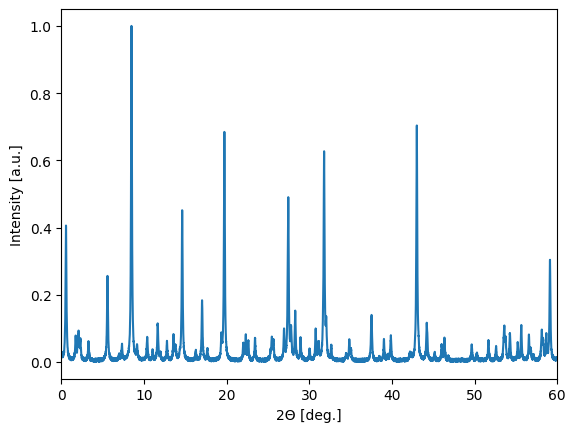

In [45]:
#plot scatter
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for i in range(1):
    plt.plot(tths,multiQC_data_list[i])
plt.xlim(tth_min,tth_max)
plt.xlabel('2Θ [deg.]')
plt.ylabel('Intensity [a.u.]')
#plt.legend()
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.show